
# Техническая часть

В данном блоке решения подключим основные библиотеки

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier

from gensim.models import Word2Vec

import warnings
warnings.filterwarnings("ignore")

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2. Get the file
downloaded = drive.CreateFile({'id':'1rkxPEPPICEu99JchWDBVKsYCFstSRWQF'})
downloaded.GetContentFile('category.csv')

downloaded = drive.CreateFile({'id':'1CjI3HQsB3Cma2SrTMLJ9PUvSHCK9r_Lp'})
downloaded.GetContentFile('test.csv')

downloaded = drive.CreateFile({'id':'1yP6LE6hbS8nICho0W7KLqoicYu4PEeA8'})
downloaded.GetContentFile('train.csv')

# Предобработка данных

## Загрузка данных

In [0]:
dtrain = pd.read_csv('train.csv', index_col=0)
dtest = pd.read_csv('test.csv', index_col=0)
dcategory = pd.read_csv('category.csv', index_col=0)

In [6]:
dtrain.shape

(489517, 4)

Посмотрим с какими категориями имеем дело:

In [7]:
dcategory

,name
category_id,
0,Бытовая электроника|Телефоны|iPhone
1,Бытовая электроника|Ноутбуки
2,Бытовая электроника|Телефоны|Samsung
3,Бытовая электроника|Планшеты и электронные кни...
4,"Бытовая электроника|Игры, приставки и программ..."
5,Бытовая электроника|Аудио и видео|Телевизоры и...
6,Бытовая электроника|Телефоны|Другие марки
7,Бытовая электроника|Настольные компьютеры
8,"Бытовая электроника|Игры, приставки и программ..."


Будем решать задачу классификации. Обучать и проверять модель будем на** dtrain**, для проверки используем метрику **accuracy**. 

Посмотрим на распределение классов, это нужно для того, чтобы понять не имеем ли мы дело с несбалансированными классами:

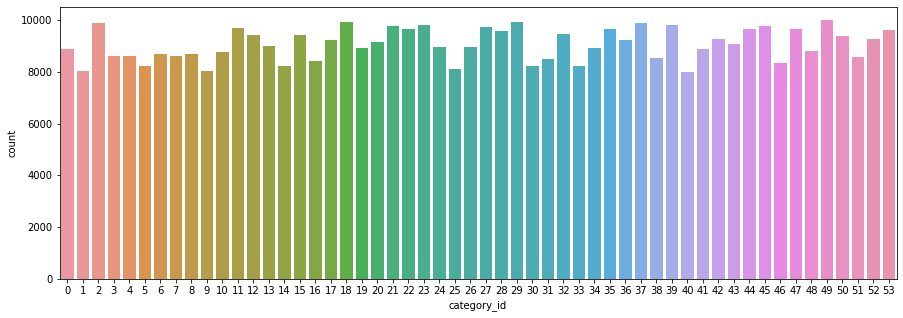

In [8]:
plt.figure(figsize=(15,5))
sns.countplot(dtrain['category_id'])

Видно на глаз, что все категории распределены +- одинаково. 

## Подготовка данных

В данном блоке мы отчистим данные и произведем лематизацию, это нужно для того, чтобы уменшить размерность будующих признаков.

In [0]:
import re

def preprocess_text(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я0-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()

Проверим, как работает функция:

In [10]:
print(preprocess_text('15 Стульев, 8 ХолодиЛьников.:'))

15 стульев 8 холодильников


In [0]:
dtrain['title'] = dtrain.apply(lambda r: preprocess_text(r['title']), axis=1)
dtrain['description'] = dtrain.apply(lambda r: preprocess_text(r['description']), axis=1)

Посмотрим на рузельтат:

In [13]:
dtrain.head()

,title,description,price,category_id
item_id,,,,
0,картина,гобелен размеры 139х84см,1000.0,19
1,стулья из прессованной кожи,продам недорого 4 стула из светлой прессованно...,1250.0,22
2,домашняя мини баня,мини баня мб 1 мини сауна предназначена для пр...,13000.0,37
3,эксклюзивная коллекция книг трансаэро подарок,продам эксклюзивную коллекцию книг выпущенную ...,4000.0,43
4,ноутбук aser,продается ноутбук acer e5 511c2ta куплен в кон...,19000.0,1


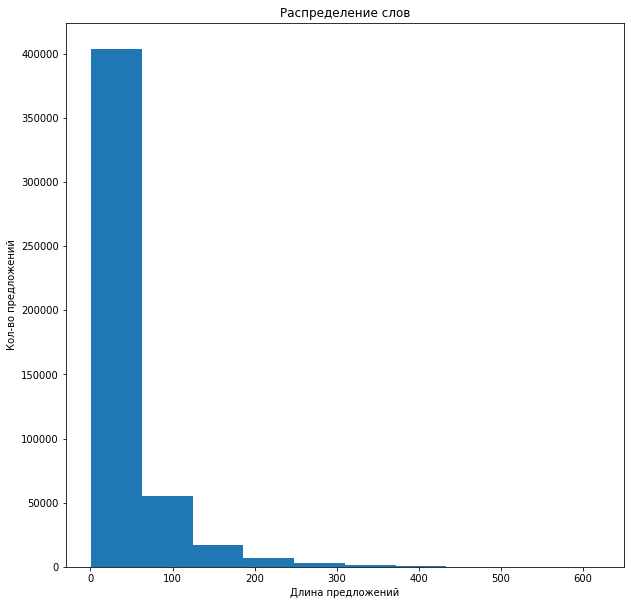

In [15]:
text = [i.split(' ') for i in dtrain['description']]
sentence_lengths = [len(tokens) for tokens in text]
# порисуем
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Длина предложений')
plt.ylabel('Кол-во предложений')
plt.title('Распределение слов')
plt.hist(sentence_lengths)
plt.show()

In [16]:
max(sentence_lengths)

619

In [17]:
dtrain['category_id'].value_counts()

49    9998
18    9932
29    9904
2     9887
37    9884
23    9804
39    9798
21    9767
45    9755
27    9732
11    9674
44    9668
35    9661
22    9655
47    9638
53    9601
28    9573
32    9451
15    9435
12    9416
50    9379
52    9264
42    9260
36    9232
17    9213
20    9142
43    9065
13    9008
24    8972
26    8948
34    8917
19    8906
41    8879
0     8862
48    8819
10    8769
8     8698
6     8697
4     8616
3     8604
7     8592
51    8584
38    8516
31    8495
16    8405
46    8343
5     8241
33    8234
14    8231
30    8223
25    8106
9     8033
1     8022
40    8009
Name: category_id, dtype: int64

Чуть-чуть обрежем предложения, но главное чтоб распределение классов сохранилось. 

In [18]:
dtrain['len'] = dtrain['description'].apply(lambda x: len(x.split(' ')))

dtrain = dtrain.where(dtrain['len'] < 200)
dtrain = dtrain.dropna()
dtrain['category_id'].value_counts()

18.0    9881
39.0    9779
2.0     9745
23.0    9721
29.0    9689
35.0    9658
44.0    9633
22.0    9620
27.0    9609
49.0    9563
37.0    9542
21.0    9531
45.0    9495
28.0    9445
53.0    9445
11.0    9421
47.0    9302
50.0    9194
42.0    9191
12.0    9170
15.0    9057
20.0    9012
32.0    8926
13.0    8922
17.0    8907
26.0    8865
0.0     8842
24.0    8824
43.0    8822
36.0    8810
19.0    8810
41.0    8770
34.0    8725
10.0    8616
8.0     8574
4.0     8550
38.0    8502
51.0    8490
3.0     8401
31.0    8386
16.0    8353
7.0     8332
52.0    8315
48.0    8266
6.0     8257
33.0    8221
14.0    8017
25.0    7979
40.0    7978
5.0     7975
30.0    7972
46.0    7957
9.0     7918
1.0     7700
Name: category_id, dtype: int64

Отлично, теперь разделим данные на обучающие и тестовые:

In [0]:
X_train, X_test, y_train, y_test = train_test_split(dtrain["description"], dtrain["category_id"],
                                                    test_size=0.3, random_state=40)

Для того, чтобы начать обучать модели необходимо текст представить числовой формат, в этом поможет **TF-IDF** преобразование и алгоритм **Word2Vec**. Я преобразую данные и через **TF-IDF**, и через **Word2Vec**, а после сравню результаты. Для классификации буду использовать ***Логистическую регрессию***. 

# ML

## TF-IDF

**TF-IDF** - это статистическая мера, используемая для оценки важности слова в контексте корпуска документа. Вес некоторого слова (n-граммы) в контексте документа, являющегося частью коллекции корпуса. 

### Векторизация данных

Я буду использовать алгоритм **TF-IDF,** который реализован в библиотеке **sklearn**. 

Чтобы улучшить качество алгоритма я использую n-граммные модели, а именно двух-граммные:

In [0]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [23]:
print('Размерность обучающего набора после векторизации: ', X_train_tfidf.shape, len(y_train))
print('Размерность тестирующего набора после векторизации: ', X_test_tfidf.shape, len(y_test))

Размерность обучающего набора после векторизации:  (335079, 3729758) 335079
Размерность тестирующего набора после векторизации:  (143606, 3729758) 143606


### Логистическая регресси

In [0]:
lr = LogisticRegression(C=5, random_state=0, solver='saga',
                        multi_class='multinomial', n_jobs=-1)
lr.fit(X_train_tfidf, y_train)

y_pred = lr.predict(X_test_tfidf)

In [25]:
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
print("Правильность на обучающем наборе: {:.3f}".format(lr.score(X_train_tfidf, y_train)))
print("Правильность на тестовом наборе: {:.3f}".format(lr.score(X_test_tfidf, y_test)))

Accuracy: 0.797
Правильность на обучающем наборе: 0.977
Правильность на тестовом наборе: 0.797


оверфитнулись, так сказать ((

Результат уже хороший, посмотрим, что покажет Word2Vec:

In [0]:
del lr

## Word2Vec

**W2V **- это инстумент для расчета векторных представлений слов. Нахождению связей между контекстами слов согласно предположению, что слова, находящие в похожих контекстах, имеют тенденцию значит похожие вещи (быть семантически близки).

In [0]:
docs = [doc.split() for doc in dtrain['text']]

Обучим W2V на наших данные с окном размером 3:

In [0]:
EMBEDDING_DIM = 70
w2v = Word2Vec(sentences=docs, size=EMBEDDING_DIM, window=5, sg=0, iter=35, min_count=1)

Посмотрим, что может W2V

Вывести лишнее слово:

In [0]:
w2v.doesnt_match(['ios', 'iphone', 'marvel'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'marvel'

Посмотреть на сколько близко расположены слова:

In [0]:
w2v.similarity('ios', 'android')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.8068313

Вывести 5 похожих слов (которые употребляются в одном контексте)

In [0]:
w2v.most_similar(positive=["ios"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('android', 0.8068312406539917),
 ('андроид', 0.7744116187095642),
 ('windows', 0.7231317162513733),
 ('os', 0.7139272689819336),
 ('miui', 0.7103722095489502),
 ('иос', 0.700728178024292),
 ('flyme', 0.689530074596405),
 ('новее', 0.6864635348320007),
 ('прошивки', 0.672870397567749),
 ('перестроится', 0.6661350131034851)]

Вывести 5 наиболее не похожих слов:

In [0]:
w2v.most_similar(negative=["ios"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('200x140', 0.5399351716041565),
 ('султан', 0.5359445810317993),
 ('антилоп', 0.528760552406311),
 ('астраханский', 0.5156436562538147),
 ('150х47', 0.5140420794487),
 ('римако', 0.512389063835144),
 ('300х250', 0.5117253065109253),
 ('40смx65см', 0.5088462233543396),
 ('90x200', 0.5061871409416199),
 ('110х90', 0.5017774701118469)]

Получит вектор:

In [0]:
w2v['ios']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-1.9834080e+00,  3.0129166e+00, -1.9111475e+00,  3.6405709e+00,
       -2.5092299e+00,  2.0648198e+00,  1.2756878e+00,  5.0522842e+00,
        1.7135998e+00,  5.5386310e+00, -9.6985906e-01,  2.9413804e-01,
        2.2261026e+00, -4.9153380e+00, -1.0661440e+00,  4.5677061e+00,
       -1.1648831e+00,  9.7966248e-01,  1.4611794e+00, -4.8260455e+00,
        1.2970511e+00,  6.8025988e-01,  7.7177949e+00,  1.0120106e+00,
        5.3005856e-02, -3.9210315e+00,  8.6374968e-02,  3.3790287e-01,
        2.7651110e-01,  3.2145083e+00, -4.5184004e-03,  3.4641225e+00,
        1.3048451e+00, -1.8690970e+00, -3.1911230e+00,  7.4548483e-01,
        3.5807984e+00,  6.8594873e-01,  3.1239171e+00,  1.3885922e+00,
        1.9921688e+00, -1.8646096e+00,  3.0613106e-01,  8.9284945e-01,
       -3.9750862e+00, -3.8593654e-02,  3.6929348e+00,  5.7284135e-02,
        3.9934301e+00,  1.3210754e+00,  1.3523301e+00, -1.7937745e+00,
        5.8702798e+00,  1.7923430e+00, -1.4721283e-01, -1.7900635e+00,
      

## Визуализация W2V

In [0]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [0]:
def tsnescatterplot(model, word, list_names):
    arrays = np.empty((0, 70), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # добaвляет вектор запроса
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # получаем список наиболее похожих слов
    close_words = model.wv.most_similar([word])
    
    # добавляет вектор для каждого из ближайших слов к массиву
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # добавляет вектор для каждого слова из list_names в массив
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Уменьшает размерность от 100 до 19 размеров с PCA
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Находит координаты t-SNE для 2 измерений
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Основной плот
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE визуализация {}'.format(word.title()))
    


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


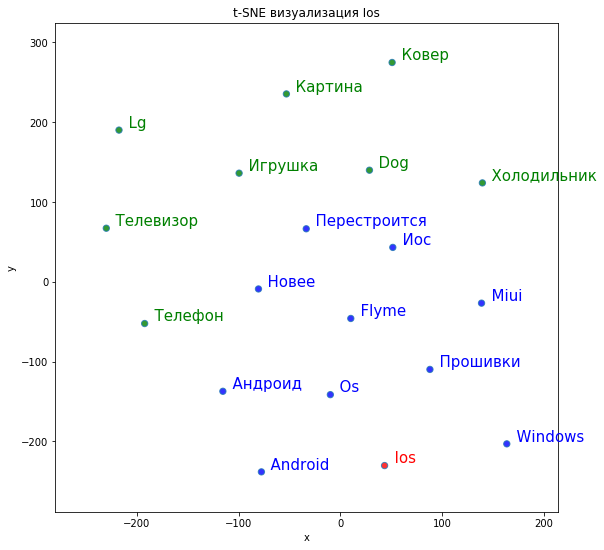

In [0]:
tsnescatterplot(w2v, 'ios', ['dog', 'игрушка', 'холодильник', 'телевизор', 'телефон', 'ковер', 'картина', 'lg'])

На данном графике я вывел 5 наиболее похожих слов и 5 случайных (на мой выбор) слов

## Логистическая регрессия

In [0]:
w2v_2 = dict(zip(w2v.wv.index2word, w2v.wv.syn0))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


Я каждому слову сопоставил вектор, но нужно решить, что сопоставить целому предложению из слов.
Один из возможных вариантов это просто усреднить все слова в предложении и получить некоторый смысл всего предложения (если слова нет в тексте, то берем нулевой вектор), данный класс решит эту задачу.



In [0]:
class mean_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(w2v_2.values())))

    def fit(self, X):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [0]:
data_mean=mean_vectorizer(w2v_2).fit(docs).transform(docs)
data_mean.shape

(489517, 70)

In [0]:
def split(train,y,ratio):
    idx = round(train.shape[0] * ratio)
    return train[:idx, :], train[idx:, :], y[:idx], y[idx:]

Xtr, Xval, ytr, yval = split(data_mean, dtrain["category_id"], 0.8)
Xtr.shape,Xval.shape,ytr.mean(),yval.mean()

((391614, 70), (97903, 70), 26.78016363051372, 26.70614792192272)

In [0]:
ytr = ytr.values
yval = yval.values

In [0]:
Xtr.shape, Xval.shape, ytr.shape, yval.shape

((391614, 70), (97903, 70), (391614,), (97903,))

Реализуем логистическую регрессию:

In [0]:
lr_w2v = LogisticRegression(C=5, random_state=0, solver='saga',
                         multi_class='multinomial', n_jobs=-1)
lr_w2v.fit(Xtr, ytr)
    # прогноз для валидационной выборки
y_pred_w2v = lr_w2v.predict(Xval)
    # считаем качество
score = accuracy_score(yval, y_pred_w2v)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [0]:
print(score)

0.8089435461630389


Модель с TF-IDF представлением слов оказалась лучше, так что будем использовать ее в предсказание категории. 

# Дип Лёрнинг?

# Предсказания 

Взглянем на **dtest**

In [0]:
dtest.head()

,title,description,price
item_id,,,
489517,Стоик журнальный сталь,продам журнальный столик изготавливаю столы из...,10000.0
489518,iPhone 5 64Gb,"Телефон в хорошем состоянии. Комплект, гаранти...",12500.0
489519,Утеплитель,ТЕПЛОПЕЛЕН-ЛИДЕР ТЕПЛА!!! Толщина утеплителя :...,250.0
489520,Пальто демисезонное,Продам пальто женское (букле) в отличном состо...,1700.0
489521,Samsung syncmaster T200N,"Условно рабочий, проблема в панели настройки м...",1000.0


Преобразуем данные

In [0]:
dtest['title'] = dtest.apply(lambda r: preprocess_text(r['title']), axis=1)
dtest['description'] = dtest.apply(lambda r: preprocess_text(r['description']), axis=1)

dtest['text'] = dtest.apply(lambda row: make_text(row['title'], row['description'],
                                              row['price']), axis=1)

In [0]:
Xtest=dtest['text'].values

In [0]:
X_tfidf = tfidf_vectorizer.transform(Xtest)

In [0]:
pred = lr.predict(X_tfidf)

In [0]:
pred.shape, dtest.shape

((243166,), (243166, 4))

In [0]:
dtest['category_id'] = pred

In [0]:
dtest.head()

,title,description,price,text,category_id
item_id,,,,,
489517,стоик журнальный сталь,продам журнальный столик изготавливаю столы из...,10000.0,стоик журнальный сталь продам журнальный столи...,22
489518,iphone 5 64gb,телефон в хорошем состоянии комплект гарантия ...,12500.0,iphone 5 64gb телефон в хорошем состоянии комп...,0
489519,утеплитель,теплопелен лидер тепла толщина утеплителя 20 м...,250.0,утеплитель теплопелен лидер тепла толщина утеп...,15
489520,пальто демисезонное,продам пальто женское букле в отличном состоян...,1700.0,пальто демисезонный продам пальто женское букл...,33
489521,samsung syncmaster t200n,условно рабочий проблема в панели настройки мо...,1000.0,samsung syncmaster t200n условно рабочий пробл...,13


Выглядит все хорошо. Теперь скачаем файл и работа готова. 

In [0]:
from google.colab import files

dtest.to_csv('baseline.csv', index=False)
files.download('baseline.csv')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 36806, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil